In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def plot_distribution(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Tokens")
    # fig.show()
    
    
def plot_alignment(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax)
    ax.set_ylabel("Tokens")
    ax.set_xlabel("Impact")
    ax.set_xticks([])    
    # fig.show()

def plot_all(project_df, save_fp=None):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax[0])
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax[1])
    ax[0].set_xticks([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Tokens Allocated")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Impact")
    ax[1].set_xticks([])
    plt.tight_layout()
    if save_fp:
        plt.savefig(save_fp)
    
    
def analyze_simulation(results, generate_plots=False):
    summary = pd.Series(results).iloc[:-1].apply(lambda x: int(x) if isinstance(x, float) else x)
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
    if generate_plots:
        plot_all(project_df)
    return summary

### Normalize to the voting that we will be doing (270k FIL)

In [4]:
## Num Projects > Quorum when sweeping Quorum
quorum_vec = list(np.arange(1, 10+1))
score_fn = ['sum']  # note quorum doesnt depend on score fn
num_applicants = 100
funding_amt = 500000
num_voters = 30
round_funds_available = 500000

# Define funding amount combinations as tuples (min_funding_amt_pct, max_funding_amt_pct)
funding_combinations = [
    (0.01, 0.15),
    (0.01, 0.20),
    (0.05, 0.15),
]

min_funding_to_fund_pct_vec = [0.05]
nsim = 25

sim_configs = list(itertools.product(quorum_vec, score_fn, funding_combinations, min_funding_to_fund_pct_vec))

results_list = []
for sim_config in tqdm(sim_configs):
    # Store raw data for this configuration
    raw_data = []
    q, score_fn, funding_tuple, min_funding_to_fund_pct  = sim_config
    
    # Unpack the funding tuple
    min_funding_amt_pct, max_funding_amt_pct = funding_tuple
    
    for i in range(nsim):
        simulation = Simulation()

        # print('#'*10)
        # print(q)
        
        min_funding_amt_badgeholder = int(min_funding_amt_pct * funding_amt)
        max_funding_amt_badgeholder = int(max_funding_amt_pct * funding_amt)
        # min_score_amt = int(min_funding_to_fund_pct * funding_amt)
        min_score_amt = 0

        simulation.initialize_round(
            max_funding=round_funds_available,
            min_project_vote=min_funding_amt_badgeholder,
            max_project_vote=max_funding_amt_badgeholder,
        )
        simulation.randomize_voters(
            num_voters=num_voters, 
            willingness_to_spend=1.0, 
            laziness_factor=0.1, 
            expertise_factor=0.9
        )
        simulation.randomize_projects(
            num_projects=num_applicants
        )

        results = simulation.simulate_voting_and_scoring(
            n=1,
            scoring_method=score_fn,
            quorum=q,
            min_amount=min_score_amt,
            normalize=True,
            count_zero_votes_towards_quorum=False
        )
        summary = analyze_simulation(results, generate_plots=False)
        raw_data.append(summary.num_projects_above_quorum_mean)
    
    # Calculate percentiles and median from raw data
    results_list.append({
        'quorum': q,
        'score_fn': score_fn,
        'funding_tuple': funding_tuple,
        'min_funding_amt_pct': min_funding_amt_pct,
        'max_funding_amt_pct': max_funding_amt_pct,
        'min_funding_to_fund_pct': min_funding_to_fund_pct,
        'raw_data': raw_data,
        'median': np.median(raw_data),
        'p5': np.percentile(raw_data, 5),
        'p95': np.percentile(raw_data, 95),
        'mean': np.mean(raw_data),
        'std': np.std(raw_data)
    })


  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(results_list)

In [6]:
df

,quorum,score_fn,funding_tuple,min_funding_amt_pct,max_funding_amt_pct,min_funding_to_fund_pct,raw_data,median,p5,p95,mean,std
0,1,sum,"(0.01, 0.15)",0.01,0.15,0.05,"[96, 97, 98, 98, 95, 93, 95, 97, 95, 98, 99, 9...",98.0,94.2,99.8,97.20,1.811077
1,1,sum,"(0.01, 0.2)",0.01,0.20,0.05,"[92, 95, 97, 96, 98, 99, 100, 97, 94, 98, 97, ...",97.0,92.4,100.0,96.80,2.416609
2,1,sum,"(0.05, 0.15)",0.05,0.15,0.05,"[87, 92, 89, 94, 91, 94, 97, 92, 93, 94, 94, 9...",92.0,88.2,94.8,92.24,2.249978
3,2,sum,"(0.01, 0.15)",0.01,0.15,0.05,"[92, 94, 97, 96, 95, 95, 91, 95, 99, 95, 93, 9...",95.0,91.0,98.8,94.64,2.725876
4,2,sum,"(0.01, 0.2)",0.01,0.20,0.05,"[96, 93, 93, 90, 87, 96, 91, 88, 95, 97, 96, 8...",94.0,87.2,96.0,93.08,3.045259
5,2,sum,"(0.05, 0.15)",0.05,0.15,0.05,"[82, 89, 88, 90, 79, 80, 86, 84, 84, 88, 84, 8...",83.0,72.6,89.8,82.52,5.262091
6,3,sum,"(0.01, 0.15)",0.01,0.15,0.05,"[94, 90, 86, 85, 85, 95, 92, 94, 91, 84, 88, 9...",91.0,85.0,94.8,90.36,3.185969
7,3,sum,"(0.01, 0.2)",0.01,0.20,0.05,"[87, 86, 90, 97, 84, 93, 89, 94, 81, 91, 94, 9...",91.0,84.4,97.0,91.44,4.205520
8,3,sum,"(0.05, 0.15)",0.05,0.15,0.05,"[50, 59, 58, 65, 54, 54, 68, 68, 63, 69, 72, 6...",65.0,51.6,71.8,63.64,6.740208
9,4,sum,"(0.01, 0.15)",0.01,0.15,0.05,"[91, 83, 91, 86, 86, 81, 83, 92, 79, 83, 92, 9...",88.0,77.4,95.6,87.00,5.535341


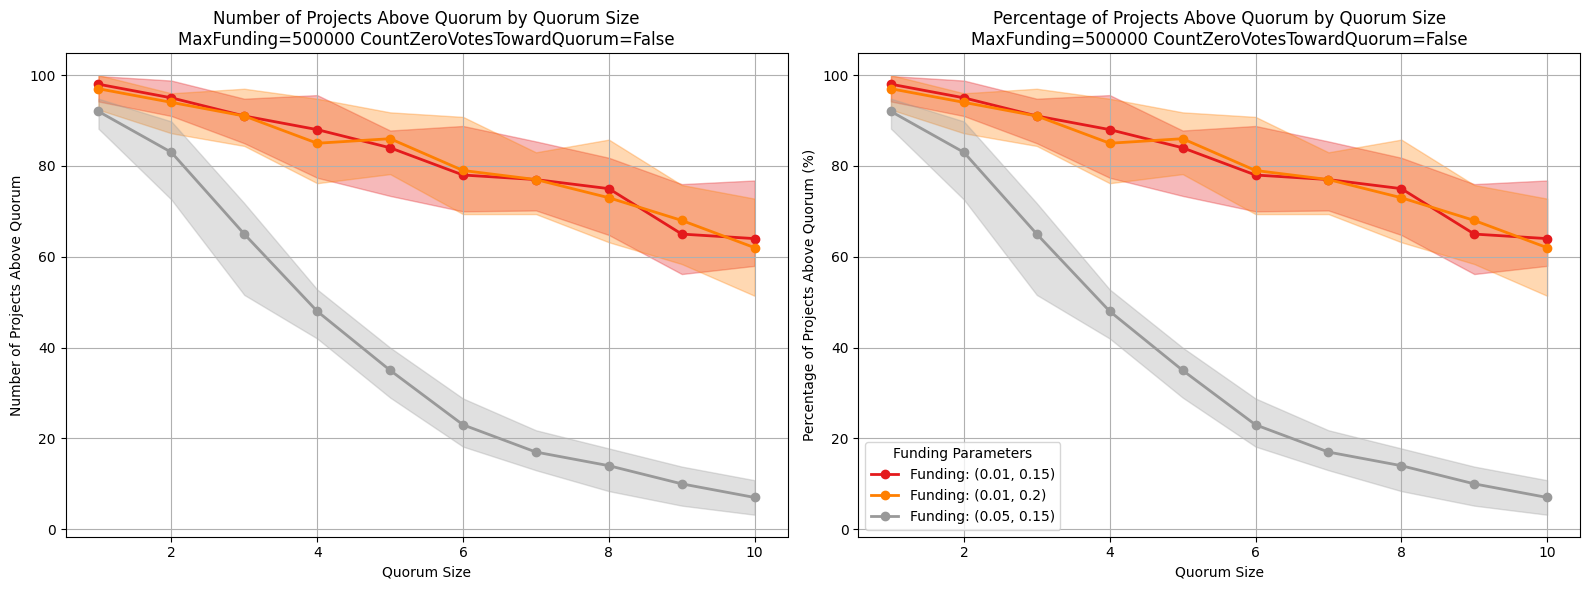

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for different parameter combinations
colors = plt.cm.Set1(np.linspace(0, 1, len(df['funding_tuple'].unique())))

color_idx = 0
# Iterate over unique funding tuples
for funding_tuple in df['funding_tuple'].unique():
    # Filter data for each funding tuple
    filtered_data = df[df['funding_tuple'] == funding_tuple]
    
    # Sort by quorum for proper plotting
    filtered_data = filtered_data.sort_values('quorum')
    
    quorum_values = filtered_data['quorum']
    median_values = filtered_data['median']
    p5_values = filtered_data['p5']
    p95_values = filtered_data['p95']
    
    # Calculate percentage values
    median_pct_values = (median_values / num_applicants) * 100
    p5_pct_values = (p5_values / num_applicants) * 100
    p95_pct_values = (p95_values / num_applicants) * 100
    
    # Create label from funding tuple
    min_funding, max_funding = funding_tuple
    label = f'Funding: ({min_funding}, {max_funding})'
    
    # LEFT PLOT: Absolute number of projects above quorum
    ax1.plot(
        quorum_values,
        median_values,
        label=label,
        color=colors[color_idx],
        linewidth=2,
        marker='o'
    )
    
    ax1.fill_between(
        quorum_values,
        p5_values,
        p95_values,
        alpha=0.3,
        color=colors[color_idx]
    )
    
    # RIGHT PLOT: Percentage of projects above quorum
    ax2.plot(
        quorum_values,
        median_pct_values,
        label=label,
        color=colors[color_idx],
        linewidth=2,
        marker='o'
    )
    
    ax2.fill_between(
        quorum_values,
        p5_pct_values,
        p95_pct_values,
        alpha=0.3,
        color=colors[color_idx]
    )
    
    color_idx += 1

# Left plot labeling
ax1.set_title('Number of Projects Above Quorum by Quorum Size\nMaxFunding=%d CountZeroVotesTowardQuorum=False' % funding_amt)
ax1.set_xlabel('Quorum Size')
ax1.set_ylabel('Number of Projects Above Quorum')
ax1.grid(True)

# Right plot labeling
ax2.set_title('Percentage of Projects Above Quorum by Quorum Size\nMaxFunding=%d CountZeroVotesTowardQuorum=False' % funding_amt)
ax2.set_xlabel('Quorum Size')
ax2.set_ylabel('Percentage of Projects Above Quorum (%)')
ax2.grid(True)

# Add legend to the right plot only
ax2.legend(title='Funding Parameters')

plt.tight_layout()
plt.show()